<div align="center">
 <img src="https://raw.githubusercontent.com/matheusmota/dataviz2018/master/resources/images/logo_facens_pos.png" width="100x">
    <h3>Aprendizado de Máquina, Redes Neurais e Deep Learning</h3>  
    <h4>Classificação de cursos Udemy</h4>
</div>


* **203066**  - Evandro Bertolucci
* **110257**  - João Victor Carvalho
* **203071**  - Louise Constantino
* **203087**  - Luiza Constantino
* **203019**  - Murilo Piva
* **203263**  - Rafael Henrique

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Esconder/Mostrar Código"></form>''')

### Importando os dados

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objects as go
import plotly.express  as px
import time
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score


df = pd.read_csv('udemy_courses.csv', encoding='latin-1')

print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'udemy_courses.csv'

In [113]:
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5 hours,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39 hours,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5 hours,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3 hours,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2 hours,2016-12-13T14:57:18Z,Business Finance


### Explorando os dados

In [114]:
df.isnull().sum()

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

In [115]:
df['subject'].value_counts()

Web Development        1200
Business Finance       1199
Musical Instruments     681
Graphic Design          603
Name: subject, dtype: int64

In [116]:
pd.DataFrame(df['subject'].value_counts()).reset_index()

,index,subject
0,Web Development,1200
1,Business Finance,1199
2,Musical Instruments,681
3,Graphic Design,603


In [117]:
temp_df = pd.DataFrame(df['subject'].value_counts()).reset_index().sort_values(by='index')

fig = go.Figure(data=[go.Pie(labels=temp_df['index'],
                             values=temp_df['subject'],
                             hole=.7,
                             marker_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)',
                 'rgb(175, 49, 35)', 'rgb(36, 73, 147)'],
                             sort=False
                            )
                     
                     ])
fig.update_layout(title='Total de Cursos por Assunto')
fig.show()

In [118]:
temp_df = pd.DataFrame(df.groupby('subject')['num_subscribers'].sum()).reset_index().sort_values(by='subject')


fig = go.Figure(data=[go.Pie(labels=temp_df['subject'],
                             values=temp_df['num_subscribers'],
                             hole=.7,
                             marker_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)',
                                             'rgb(175, 49, 35)', 'rgb(36, 73, 147)'],
                             sort=False
                            )
                     
                     ])
fig.update_layout(title='Total de Inscritos por Assunto')
fig.show()

In [119]:

temp_df = pd.DataFrame(df.groupby('subject')['num_subscribers'].mean().round(2)).reset_index().sort_values(by='num_subscribers', ascending=False)
fig = px.bar(temp_df, x='subject', y='num_subscribers', text='num_subscribers', title='Média de Inscritos por Assunto')
fig.show()

### Tratando o Vocabulário

In [163]:
#Limpar coluna URL
df['clean_url'] = df['url'].str.replace('https://www.udemy.com/','')
df['clean_url'] = df['clean_url'].str.replace('/','')
df['clean_url'] = df['clean_url'].str.replace('-',' ')

In [164]:
#Criar coluna juntando as colunas 'Course Title' e 'Clean Url'
df['course_url'] = df['course_title'] + ' ' + df['clean_url']

In [165]:
#Criar novo DataFrame apenas com as colunas necessárias para analise
dfCursos = df[['course_title', 'url', 'course_url', 'subject']]
dfCursos.describe()

,course_title,url,course_url,subject
count,3683,3683,3683,3683
unique,3668,3677,3677,4
top,Creating an animated greeting card via Google ...,https://www.udemy.com/cfa-level-2-quantitative...,MicroStation - CÃ©lulas microstation celulas,Web Development
freq,3,2,2,1200


In [166]:
#Função para limpar campos
def clean_text(text):
    # remove barra invertida-apóstrofo
    text = re.sub("\'", "", text)
    # remove tudo, exceto alfabetos
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove os espaços em branco
    text = ' '.join(text.split())
    # converter texto em minúsculas
    text = text.lower()
    
    return text

In [167]:
#Aplica a função de limpar o campo na coluna 'Course Url'
dfCursos['clean_course'] = dfCursos['course_url'].apply(lambda x: clean_text(x))
dfCursos.head()

C:\Users\rafae\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,course_title,url,course_url,subject,clean_course
0,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,Ultimate Investment Banking Course ultimate in...,Business Finance,ultimate investment banking course ultimate in...
1,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,Complete GST Course & Certification - Grow You...,Business Finance,complete gst course certification grow your ca...
2,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,Financial Modeling for Business Analysts and C...,Business Finance,financial modeling for business analysts and c...
3,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,Beginner to Pro - Financial Analysis in Excel ...,Business Finance,beginner to pro financial analysis in excel co...
4,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,How To Maximize Your Profits Trading Options h...,Business Finance,how to maximize your profits trading options h...


### Top 30 palavras mais frequentes

In [168]:
#Função para contar a frequencia de cada palavra em determinada coluna
def freq_words(x, s, terms = 30):
    if s == False:
        all_words = [text for text in x]
    else:
        all_words = ' '.join([text for text in x])
        all_words = all_words.split()
  
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(12,15))
    ax = sns.barplot(data=d, x= "count", y = "word")
    ax.set(ylabel = 'Word')
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)
    plt.show()

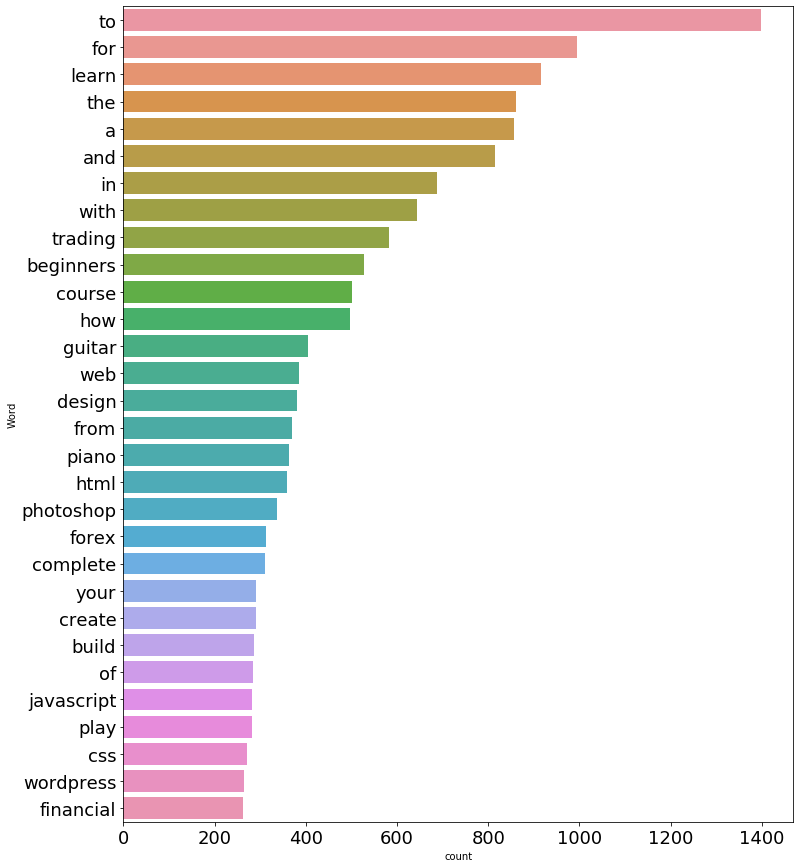

In [169]:
# print 100 most frequent words
freq_words(dfCursos['clean_course'], True, 30)

In [170]:
#Download do pacote de palavras irrelevantes da biblioteca NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
#Função para remover as palavras irrelevantes
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [172]:
#Removendo as palavras irrelevantes da coluna 'Clean Course'
dfCursos['clean_course'] = dfCursos['clean_course'].apply(lambda x: remove_stopwords(x))

C:\Users\rafae\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Palavras mais frequentes, após tratamento

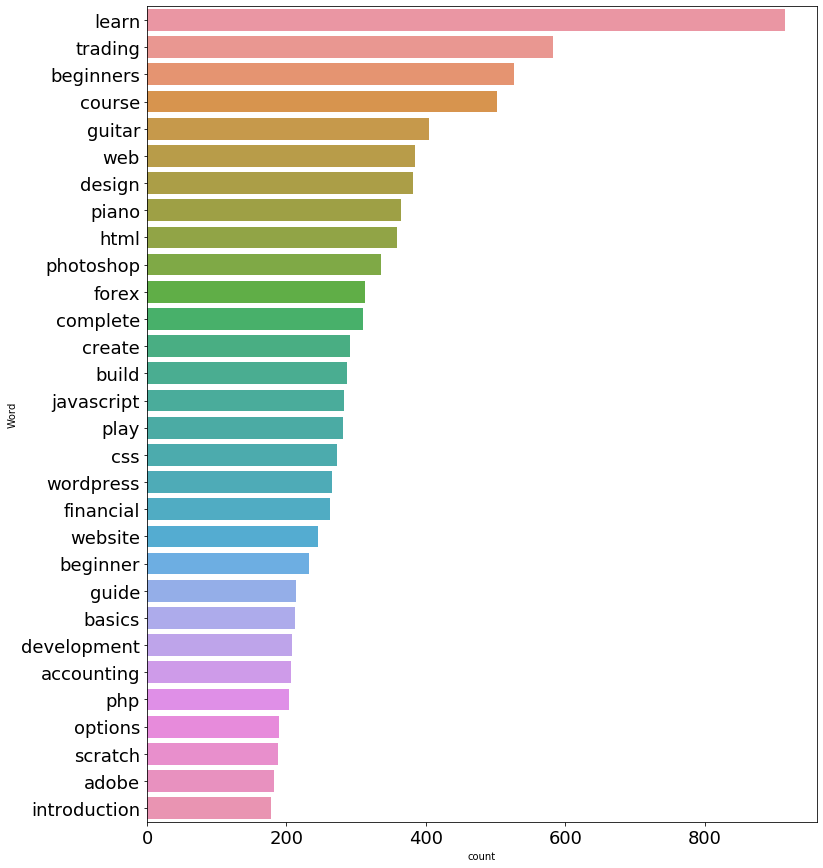

In [173]:
freq_words(dfCursos['clean_course'], 50)

In [131]:
def plotWordCloud(subject):
    text = dfCursos
    text =  ''.join(text[text['subject'] == subject]['clean_course'])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)
    plt.figure(figsize = (15, 10)) 
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.title(subject, fontsize=20);
    plt.show()

### Palavras mais frequentes por Assunto

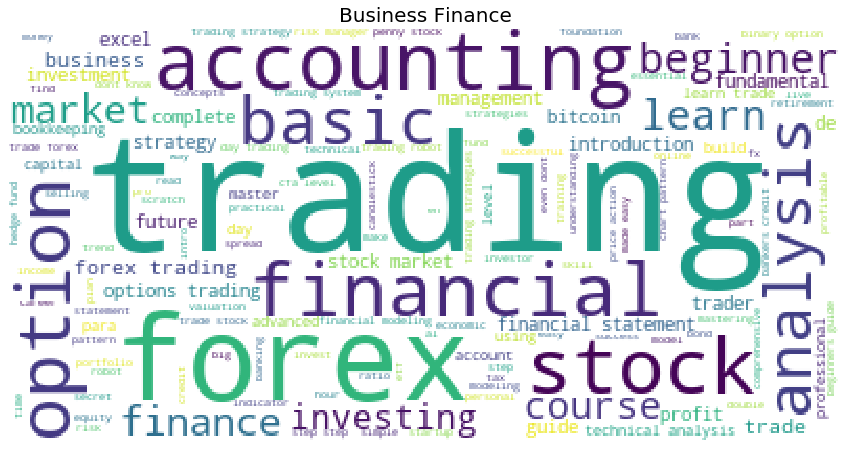

In [132]:
plotWordCloud('Business Finance')

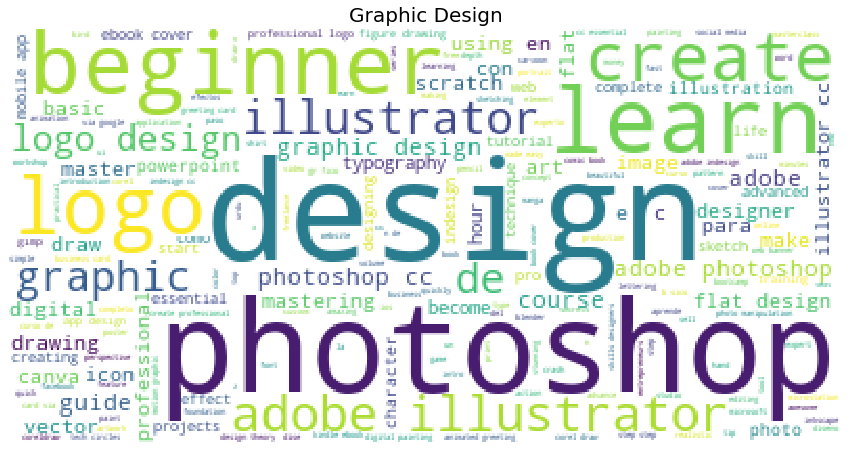

In [133]:
plotWordCloud('Graphic Design')

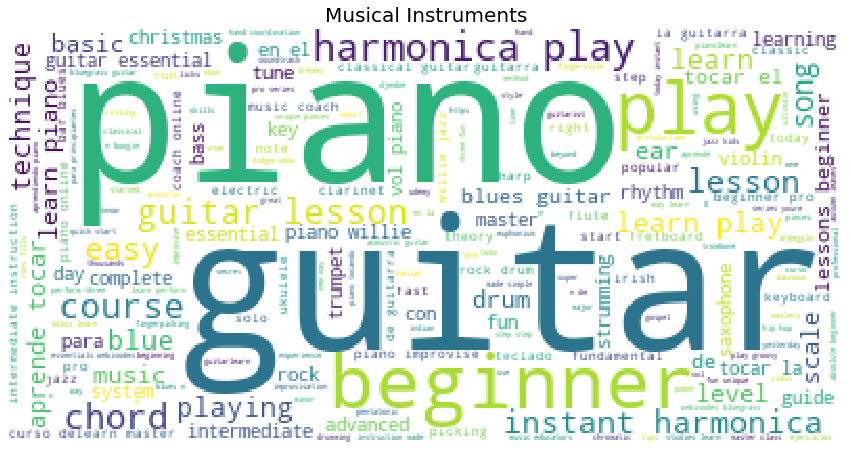

In [134]:
plotWordCloud('Musical Instruments')

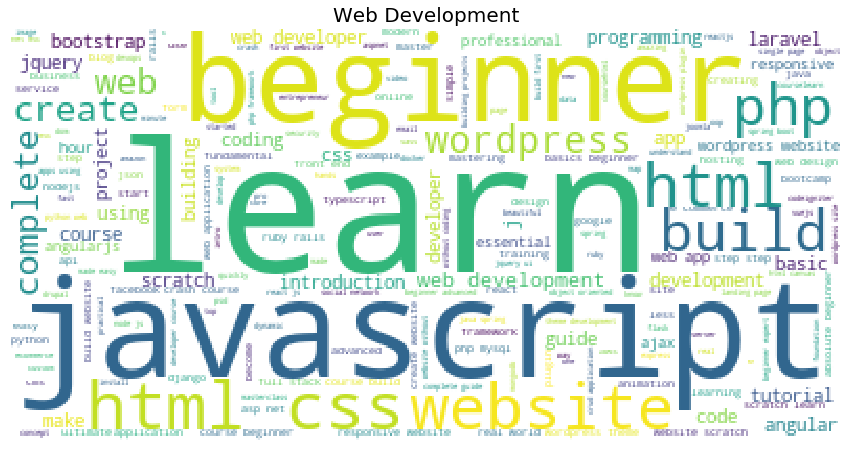

In [135]:
plotWordCloud('Web Development')

### Modelos

In [46]:
# criando vocabulário
          
def palavrasVocabulario(qtdLinhaPorRotulo, dadosUdemy_Tratados):
    vocabulario = []

    for subject in dadosUdemy_Tratados['subject'].unique():
        for row in dadosUdemy_Tratados[dadosUdemy_Tratados['subject'] == subject]['clean_course'][:qtdLinhaPorRotulo]:
            for p in row.lower().split():
                p = p.replace(' ','')
                if p not in vocabulario:
                    vocabulario.append(p)
    
    return vocabulario

            

In [68]:
# agora é necessário representar cada frase usando o vocabulário
def Gerar_Amostras(dfCursos, vocabulario):
    amostras = []
    for t in list(dfCursos['clean_course']):
        amostra = []
        for p in vocabulario:
            if p in t.lower().replace('.','').split():
                amostra.append(1)
            else:
                amostra.append(0)

        amostras.append(amostra)

    return np.array(amostras)

## Comparando Modelos

### BernoulliNB | ComplementNB | MultinomialNB - Sem Validação Cruzada

In [85]:
dfCompare = pd.DataFrame(columns=['Modelo','BernoulliNB', 'ComplementNB', 'MultinomialNB'])

vocabulario = palavrasVocabulario(200,dfCursos)
amostras = Gerar_Amostras(dfCursos, vocabulario)  
    
X_train, X_test, y_train, y_test = train_test_split(amostras, df['subject'], test_size=0.33, random_state=42)


start_time_bnb = time.time()
model_bnb = BernoulliNB()
model_bnb.fit(X_train, y_train)
y_pred_bnb = model_bnb.predict(X_test)
process_bnb = '%s"' % round((time.time() - start_time_bnb),5)


start_time_cnb = time.time()
model_cnb = ComplementNB()
model_cnb.fit(X_train, y_train)
y_pred_cnb = model_cnb.predict(X_test)
process_cnb = '%s"' % round((time.time() - start_time_cnb),5)


start_time_mnb = time.time()
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred_mnb = model_mnb.predict(X_test)
process_mnb = '%s"' % round((time.time() - start_time_mnb),5)


dfCompare = dfCompare.append({'Modelo': 'Acurácia',
                              'BernoulliNB': accuracy_score(y_test, y_pred_bnb), 
                              'ComplementNB':accuracy_score(y_test, y_pred_cnb),
                              'MultinomialNB':accuracy_score(y_test, y_pred_mnb)}, ignore_index=True)

dfCompare = dfCompare.append({'Modelo':'Processamento',
                              'BernoulliNB': process_bnb, 
                              'ComplementNB':process_cnb,
                              'MultinomialNB':process_mnb}, ignore_index=True)
    
print(dfCompare)
    

          Modelo BernoulliNB ComplementNB MultinomialNB
0       Acurácia    0.945724     0.955592      0.934211
1  Processamento    0.11363"     0.09175"      0.09674"


### BernoulliNB | ComplementNB | MultinomialNB - Com Validação Cruzada

In [86]:
dfCompare = pd.DataFrame(columns=['Modelo','BernoulliNB', 'ComplementNB', 'MultinomialNB'])
    
vocabulario = palavrasVocabulario(200,dfCursos)
amostras = Gerar_Amostras(dfCursos, vocabulario)  
    
X_train, X_test, y_train, y_test = train_test_split(amostras, df['subject'], test_size=0.33, random_state=42)


start_time_bnb = time.time()
model_bnb = BernoulliNB()
model_bnb.fit(X_train, y_train)
y_pred_bnb = model_bnb.predict(X_test)
scores_bnb = cross_val_score(model_bnb, X_train, y_train, cv=5)
process_bnb = '%s"' % round((time.time() - start_time_bnb),5)


start_time_cnb = time.time()
model_cnb = ComplementNB()
model_cnb.fit(X_train, y_train)
y_pred_cnb = model_cnb.predict(X_test)
scores_cnb = cross_val_score(model_cnb, X_train, y_train, cv=5)
process_cnb = '%s"' % round((time.time() - start_time_cnb),5)


start_time_mnb = time.time()
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred_mnb = model_mnb.predict(X_test)
scores_mnb = cross_val_score(model_mnb, X_train, y_train, cv=5)
process_mnb = '%s"' % round((time.time() - start_time_mnb),5)


dfCompare = dfCompare.append({'Modelo': 'Acurácia',
                              'BernoulliNB': scores_bnb.mean(), 
                              'ComplementNB':scores_cnb.mean(),
                              'MultinomialNB':scores_mnb.mean()}, ignore_index=True)

dfCompare = dfCompare.append({'Modelo':'Processamento',
                              'BernoulliNB': process_bnb, 
                              'ComplementNB':process_cnb,
                              'MultinomialNB':process_mnb}, ignore_index=True)
    
print(dfCompare)
    

          Modelo BernoulliNB ComplementNB MultinomialNB
0       Acurácia    0.932704     0.945682      0.930282
1  Processamento    0.66572"     0.49719"      0.53212"


### ComplementNB - Testando diferentes parâmetros

In [87]:
#Pegando o melhor modelo e testando diferentes parâmetros ( ComplementNB )

dfCompare = pd.DataFrame(columns=['CV', 'Acurácia', 'Processamento'])

vocabulario = palavrasVocabulario(200,dfCursos)
amostras = Gerar_Amostras(dfCursos, vocabulario)  
    
X_train, X_test, y_train, y_test = train_test_split(amostras, df['subject'], test_size=0.33, random_state=42)



for i in range(2,11):
    start_time = time.time()

    model = ComplementNB()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, X_train, y_train, cv=i)
    process = '%s"' % round((time.time() - start_time),5)
    
    dfCompare = dfCompare.append({'CV': i, 
                                  'Acurácia': scores.mean(),
                                  'Processamento':process}, ignore_index=True)
  
    
print(dfCompare)
        

   CV  Acurácia Processamento
0   2  0.939197      0.18949"
1   3  0.944467      0.35206"
2   4  0.945680      0.44732"
3   5  0.945682        0.569"
4   6  0.946082      0.67271"
5   7  0.945686      0.74208"
6   8  0.946900      0.79442"
7   9  0.948112      0.91484"
8  10  0.947707       1.0233"


### KNeighbors 

In [179]:
# KNeighbors simples

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

dfCompare = pd.DataFrame(columns=['KNeighbors','CV', 'Acurácia', 'Processamento'])

vocabulario = palavrasVocabulario(200,dfCursos)
amostras = Gerar_Amostras(dfCursos, vocabulario)  
    
X_train, X_test, y_train, y_test = train_test_split(amostras, df['subject'], test_size=0.33, random_state=42)



for i in [2,3,5,10]:
    start_time = time.time()
    
    model = KNeighborsClassifier()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, X_train, y_train, cv=i)
    
    process = '%s"' % round((time.time() - start_time),5)
    
    dfCompare = dfCompare.append({'KNeighbors':'Simples',
                                  'CV': i, 
                                  'Acurácia': scores.mean(),
                                  'Processamento':process}, ignore_index=True)
print(dfCompare)

  KNeighbors  CV  Acurácia Processamento
0    Simples   2  0.669225     19.02302"
1    Simples   3  0.711778     22.40371"
2    Simples   5  0.702069     27.81788"
3    Simples  10  0.736111     34.22931"


In [180]:
#KNeighbors Bagging (c/ 10 estimators)

model = BaggingClassifier(KNeighborsClassifier(), max_samples=0.75, max_features=0.75, random_state = 42)

vocabulario = palavrasVocabulario(5,dfCursos)
amostras = Gerar_Amostras(dfCursos, vocabulario)  
    
X_train, X_test, y_train, y_test = train_test_split(amostras, df['subject'], test_size=0.33, random_state=42)


for i in [2,3,5,10]:
    start_time = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, X_train, y_train, cv=i)
    
    process = '%s"' % round((time.time() - start_time),5)
    
    dfCompare = dfCompare.append({'KNeighbors':'10 estimators',
                                  'CV': i, 
                                  'Acurácia': scores.mean(),
                                  'Processamento':process}, ignore_index=True)
print(dfCompare)

      KNeighbors  CV  Acurácia Processamento
0        Simples   2  0.669225     19.02302"
1        Simples   3  0.711778     22.40371"
2        Simples   5  0.702069     27.81788"
3        Simples  10  0.736111     34.22931"
4  10 estimators   2  0.768135      5.05855"
5  10 estimators   3  0.746672      6.62165"
6  10 estimators   5  0.759616      7.58251"
7  10 estimators  10  0.755953      9.46638"


### Testando novas amostras

In [90]:
# como testar com uma amostra nova

def testarAmostra(amostra_nova):
    amostra = []

    for p in vocabulario:
        if p in amostra_nova.lower().replace('.','').split():
            amostra.append(1)
        else:
            amostra.append(0)


    print('Course: ',amostra_nova)    
    print('Predicted subject: ',model.predict([amostra]))
    print(model.predict_proba([amostra]))
    print('')


In [91]:
testarAmostra('Web Development With Google Maps')
testarAmostra('How to play Contemporary Piano')
testarAmostra('Easy Steps To Become A Photoshop Expert')
testarAmostra('Learn Basic Concepts of Economics Step by Step - Complete')

Course:  Web Development With Google Maps
Predicted subject:  ['Web Development']
[[0.08 0.08 0.02 0.82]]

Course:  How to play Contemporary Piano
Predicted subject:  ['Musical Instruments']
[[0. 0. 1. 0.]]

Course:  Easy Steps To Become A Photoshop Expert
Predicted subject:  ['Business Finance']
[[0.34 0.2  0.16 0.3 ]]

Course:  Learn Basic Concepts of Economics Step by Step - Complete
Predicted subject:  ['Web Development']
[[0.14 0.1  0.16 0.6 ]]



### Convertendo Texto em Características

Usando o OneHotEncode() do sklearn para codificar a variável de destino. Uma vez que existem 4 tags de assunto exclusivas, haverá 4 novas variáveis de destino.

In [92]:
# Instatniate One-Hot-Encoder
ohe = OneHotEncoder(categories = "auto",sparse = False)

# One-Hot-Encode Class column of df
y = ohe.fit_transform(dfCursos[['subject']])

In [93]:
#Dividindo os dados em treino (80%) e teste (20%)
xtrain, xval, ytrain, yval = train_test_split(dfCursos['clean_course'], y, test_size=0.2, random_state=9)

In [94]:
#Usando os resursos do TF-IDF para processar os dados de texto
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000)

tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [95]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [96]:
#Construindo um modelo de regressão logística por ser mais rápido para treinar com poucos recursos.
#Usando a classe OneVsRestClassifier do sk-learn para resolver como um problema de relev6ancia binária
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [97]:
#Ajuste do modelo no conjunto de treino
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [98]:
# Fazendo a predição no conjunto de validação
y_pred = clf.predict(xval_tfidf)


In [99]:
#Verificando um exemplo de previsão
y_pred[5]

array([0, 0, 0, 0])

In [100]:
#Usando a função inverse_transform junto com o OneHotencode para converter a matriz prevista
ohe.inverse_transform(y_pred)[5]

array(['Business Finance'], dtype=object)

In [101]:
# Avaliar o desempenho
print('Desempenho:',f1_score(yval, y_pred, average="micro"))

Desempenho: 0.9049373618275609


Obtivemos uma pontuação decente na F1 de 0,916. Essas previsões foram feitas com base em um valor limite de 0,5, o que significa que as probabilidades maiores ou iguais a 0,5 foram convertidas em 1 e as demais em 0.

Testando outros valores de limites:

In [102]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

# evaluate performance
print('Desempenho:',f1_score(yval, y_pred_new, average="micro"))

Desempenho: 0.9481582537517053


### Criar função de inferência

Construir uma função de inferência. Ele pegará um curso e seguirá as etapas abaixo:

*   Limpe o texto
*   Remova as palavras irrelevantes do texto limpo
*   Extraia recursos do texto
*   Fazer previsões
*   Retorna as tags subject previstas

In [103]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    r = ohe.inverse_transform(q_pred)
    r = r[0]
    r = r[0]
    return r

### Testando novas amostras

In [104]:
#Testando alguns exemplos

count = 0
rg = 10
for i in range(rg):
    k = xval.sample(1).index[0]
    print("Course: ", dfCursos['course_title'][k])
    print("Predicted subject: ", infer_tags(xval[k]))
    print("Actual subject: ", dfCursos['subject'][k])  
    if infer_tags(xval[k]) == dfCursos['subject'][k]:
        print("Answer: Right", "\n")
        count = count + 1
    else:
        print("Answer: Wrong", "\n")

print("Total Predictions: ", rg)
print("Correct Predictions: ", count)
print("% Correct: ", (count/rg)*100)

Course:  Learn how to quickly build websites using Wordpress
Predicted subject:  Web Development
Actual subject:  Web Development
Answer: Right 

Course:  JavaScript Tutorial: Learn JavaScript Code for Beginners
Predicted subject:  Web Development
Actual subject:  Web Development
Answer: Right 

Course:  10.  Bonds and Bond Pricing
Predicted subject:  Business Finance
Actual subject:  Business Finance
Answer: Right 

Course:  JSON in Action: Build JSON-Based Applications
Predicted subject:  Web Development
Actual subject:  Web Development
Answer: Right 

Course:  Photoshop: Creando efectos de luz
Predicted subject:  Graphic Design
Actual subject:  Graphic Design
Answer: Right 

Course:  Curso de piano 101 - Tocando partituras y acordes -
Predicted subject:  Musical Instruments
Actual subject:  Musical Instruments
Answer: Right 

Course:  App Design + Web Design + Photoshop = Combined Course
Predicted subject:  Graphic Design
Actual subject:  Graphic Design
Answer: Right 

Course:  Insp